In [2]:
!pip install numpy pandas matplotlib scikit-learn xgboost seaborn onnxmltools onnx

Defaulting to user installation because normal site-packages is not writeable
distutils: /mmfs1/home/paul.williams.1/.local/lib/python3.9/site-packages
sysconfig: /mmfs1/home/paul.williams.1/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = "/mmfs1/home/paul.williams.1/roadsense/fastapi-backend/Result.csv"
df = pd.read_csv(data_path)

# Preview the data
df.head()


,Unnamed: 0,level_0,line_i,NAME,Shape__Len,geometry,point,snap_dist,index,accelerationY,accelerationZ,speedv,Label1,datetime,unixTimestamp,latitude,longitude,IRI_3
0,0,0,262.0,ELLIS BLVD,370.366629,LINESTRING (-92.1893378216014 38.5510324585636...,POINT (-92.19174787 38.55151575),0.000042,13445,-0.077255,0.053024,19,ELLIS BLVD,2022-08-11 20:02:09.035953920-05:00,1660248129,38.551516,-92.191748,67.92614
1,1,1,262.0,ELLIS BLVD,370.366629,LINESTRING (-92.1893378216014 38.5510324585636...,POINT (-92.19174787 38.55151575),0.000042,13446,-0.059265,0.153824,19,ELLIS BLVD,2022-08-11 20:02:09.045950976-05:00,1660248129,38.551516,-92.191748,67.92614
2,2,2,262.0,ELLIS BLVD,370.366629,LINESTRING (-92.1893378216014 38.5510324585636...,POINT (-92.19174787 38.55151575),0.000042,13447,-0.065826,0.191589,19,ELLIS BLVD,2022-08-11 20:02:09.055015936-05:00,1660248129,38.551516,-92.191748,67.92614
3,3,3,262.0,ELLIS BLVD,370.366629,LINESTRING (-92.1893378216014 38.5510324585636...,POINT (-92.19174787 38.55151575),0.000042,13448,-0.064240,0.077881,19,ELLIS BLVD,2022-08-11 20:02:09.066046976-05:00,1660248129,38.551516,-92.191748,67.92614
4,4,4,262.0,ELLIS BLVD,370.366629,LINESTRING (-92.1893378216014 38.5510324585636...,POINT (-92.19174787 38.55151575),0.000042,13449,-0.039688,0.007767,19,ELLIS BLVD,2022-08-11 20:02:09.075922944-05:00,1660248129,38.551516,-92.191748,67.92614


In [4]:
print(f"Total rows before removing duplicates: {len(df)}")

duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Total rows before removing duplicates: 662810
Number of duplicate rows: 0


In [5]:
missing_values = df.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
Unnamed: 0         0
level_0            0
line_i             0
NAME               0
Shape__Len         0
geometry           0
point              0
snap_dist          0
index              0
accelerationY      0
accelerationZ      0
speedv             0
Label1             0
datetime           0
unixTimestamp      0
latitude           0
longitude          0
IRI_3            810
dtype: int64


In [6]:
# drop missing values
df = df.dropna()

In [7]:
missing_values_new = df.isnull().sum()
print("Missing Values per Column after dropping columns:")
print(missing_values_new)

Missing Values per Column after dropping columns:
Unnamed: 0       0
level_0          0
line_i           0
NAME             0
Shape__Len       0
geometry         0
point            0
snap_dist        0
index            0
accelerationY    0
accelerationZ    0
speedv           0
Label1           0
datetime         0
unixTimestamp    0
latitude         0
longitude        0
IRI_3            0
dtype: int64


In [8]:
# final length of df
print(f"Total rows before removing missing values: {len(df)}")


Total rows before removing missing values: 662000


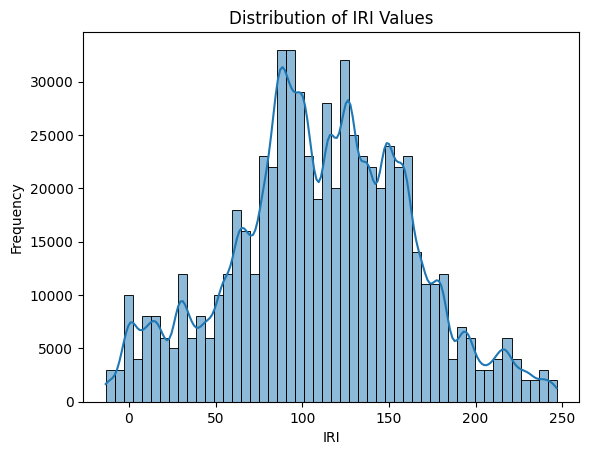

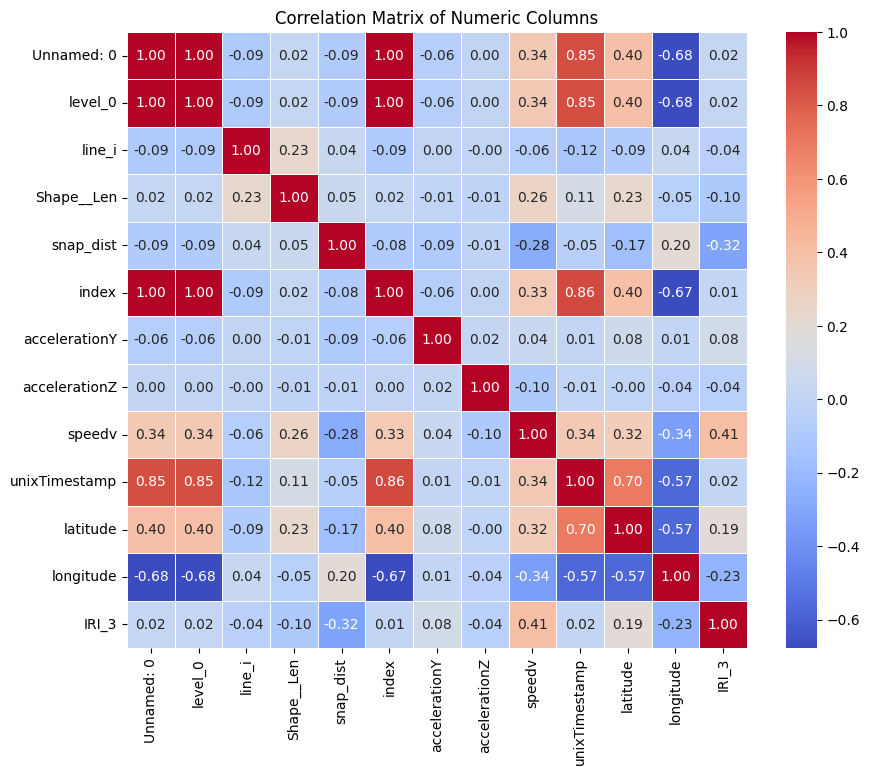

In [9]:
# Distribution of IRI values
sns.histplot(df['IRI_3'], bins=50, kde=True)
plt.title("Distribution of IRI Values")
plt.xlabel("IRI")
plt.ylabel("Frequency")
plt.show()


# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Check correlation
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numeric Columns")
plt.show()



In [10]:
# Define feature columns and target variable
features = ['accelerationY', 'accelerationZ', 'speedv', 'unixTimestamp','latitude', 'longitude']
target = 'IRI_3'

# Split into features and target
X = df[features]
y = df[target]


In [11]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Training samples: 529600
Test samples: 132400


In [18]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,  # Number of trees
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Save model
xgb_model.save_model("xgb_iri_model.json")


In [19]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 5.0948
RMSE: 9.0073
R² Score: 0.9697


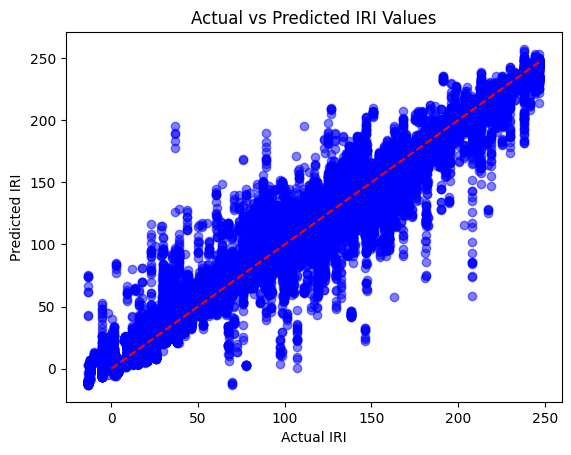

In [20]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual IRI")
plt.ylabel("Predicted IRI")
plt.title("Actual vs Predicted IRI Values")
plt.plot([0, max(y_test)], [0, max(y_test)], linestyle='--', color='red')
plt.show()

In [46]:
import xgboost as xgb

# Load the XGBoost model from the JSON file
xgb_model = xgb.XGBRegressor()
xgb_model.load_model("xgb_iri_model.json")

In [47]:
! pip install hummingbird-ml



Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 166 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.9 MB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 97.9 MB/s eta 0:00:01
     |████████████████████████████████| 766.7 MB 48 kB/s s eta 0:00:012
     |████████████████████████████████| 193 kB 126.4 MB/s eta 0:00:01
     |████████████████████████████████| 127.9 MB 147.6 MB/s eta 0:00:01
     |████████████████████████████████| 664.8 MB 73 kB/s /s eta 0:00:01
     |████████████████████████████████| 207.5 MB 134.6 MB/s eta 0:00:01
     |████████████████████████████████| 363.4 MB 112.6 MB/s eta 0:00:01
     |████████████████████████████████| 211.5 MB 303 kB/s eta 0:00:0101
     |████████████████████████████████| 1.6 MB 104.1 MB/s eta 0:00:01
     |████████████████████████████████| 24.6 MB 109.2 MB/s eta 0:00:01
     |████████████████████████████████| 13.8 MB 117.6 MB/s eta 0:00:01
 

In [48]:
from hummingbird.ml import convert

# Convert the loaded XGBoost model to PyTorch
pytorch_model = convert(xgb_model, 'pytorch')

# Save the PyTorch model as a .pt file
import torch

# Dummy input with the appropriate shape (same as feature count)
import numpy as np
dummy_input = torch.from_numpy(np.random.rand(1, len(X_train.columns)).astype(np.float32))

# Trace and save the PyTorch model
traced_model = torch.jit.trace(pytorch_model.model, dummy_input)
traced_model.save("xgb_model.pt")
print("Model successfully converted and saved as xgb_model.pt!")


Model successfully converted and saved as xgb_model.pt!


In [49]:
! pip install onnx


Defaulting to user installation because normal site-packages is not writeable
distutils: /mmfs1/home/paul.williams.1/.local/lib/python3.9/site-packages
sysconfig: /mmfs1/home/paul.williams.1/.local/lib64/python3.9/site-packages
user = True
home = None
root = None
prefix = None


In [50]:
import torch
import torch.onnx

# Export the model to ONNX
torch.onnx.export(
    traced_model,                     # PyTorch model
    dummy_input,                      # Dummy input tensor
    "xgb_model.onnx",                 # Output ONNX file
    export_params=True,               # Store model parameters
    opset_version=11,                 # ONNX version
    do_constant_folding=True,         # Fold constant nodes
    input_names=['input'],            # Input names
    output_names=['output']           # Output names
)

print("Model successfully converted and saved as xgb_model.onnx!")


Model successfully converted and saved as xgb_model.onnx!


/mmfs1/home/paul.williams.1/.local/lib/python3.9/site-packages/torch/onnx/utils.py:780: UserWarning: no signature found for <torch.ScriptMethod object at 0x1554d0f6f6d0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
